# Desafio técnico CERTI

### 1. Download do dataset

In [1]:
# Baixando dados
#!wget -nc  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
#!wget -nc  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
#!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
#!rm  images/*.mat

### 2. Importação das bibliotecas

In [2]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from utils import *


from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

### 3.  Seleção das 2000 amostras

**A seleção das amostras foi feita da seguinte forma, como o dataset possui 25 raças de cachorros e 12 raças de gatos, foram selecionadas 40 imagens aleatórias de cada raça de cachorro, totalizando 1000 amostras de cachorros e 83 imagens de cada raça de gato, totalizando 996 amostras de gatos.**

In [3]:
# Criando lista com os nome das imagens baixadas
pasta_dados = "images/"
nome_imagens = [os.path.basename(file) for file in glob.glob(os.path.join(pasta_dados, '*.jpg'))]
print(f"Quantidade de imagens: {len(nome_imagens)}")

Quantidade de imagens: 7390


In [4]:
racas = [' '.join(name.split('_')[:-1]) for name in nome_imagens ] #RACAS É LABELS
print(f"Quantidade de raças: {len(np.unique(racas))}")

Quantidade de raças: 37


In [5]:
# Criando um dicionario com as chaves sendo o nome das raças dos animais
# e os valores sendo os índices das imagens
dic = {}
for imagem in nome_imagens:
    nome = imagem.rsplit('_', 1)[0]
    indice = nome_imagens.index(imagem)
    if nome not in dic:
        dic[nome] = [indice]
        
    else:
        dic[nome].append(indice)

In [6]:
# Selecionando 40 imagens de cada raça de cachorro e 83 imagens de cada raça de gato, totalizando 1996 amostras.
indices = []
for raca in dic.keys():
    if maiuscula(raca):
        indices.append(dic[raca][0:83]) # Serão as primeiras 83 imagens de cada raça de gato, pois são 12 raças, totalizando 996 amostras de gatos
    else:
        indices.append(dic[raca][0:40])# Serão as primeiras 40 imagens de cada raça de cachorro, pois são 25 raças, totalizando 1000 amostras de cachorros
    
lista_indices = list(itertools.chain(*indices))

nome_imagens_filtrado = []
for i in lista_indices:
    imagem = nome_imagens[i]
    nome_imagens_filtrado.append(imagem)

In [7]:
print(f'Quantidade de amostras:', len(nome_imagens_filtrado))

Quantidade de amostras: 1996


### 4. Criaçaõ das labels( 0 =  gato e 1 = cachorro) e imgData (imagens)

In [8]:
tamanho_imagem = (256, 256)
data = []
labels = []

# Carrega as imagens e cria as labels para saber se é cachorro ou gato
for imagem in nome_imagens_filtrado:
    nome_raca = imagem.rsplit('_', 1)[0]
    if maiuscula(nome_raca):
        labels.append(0) #GATO
    else:
        labels.append(1) #CACHORRO
    
    img = load_img(os.path.join('images/',imagem))
    img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), *tamanho_imagem).numpy().astype('uint8')
    data.append(img)

imgData = np.array(data)
labels = np.array(labels)

In [9]:
imgData.shape

(1996, 256, 256, 3)

In [10]:
labels.shape

(1996,)

### 4.1 Plot de algumas imagens com as labels e nome do arquivo

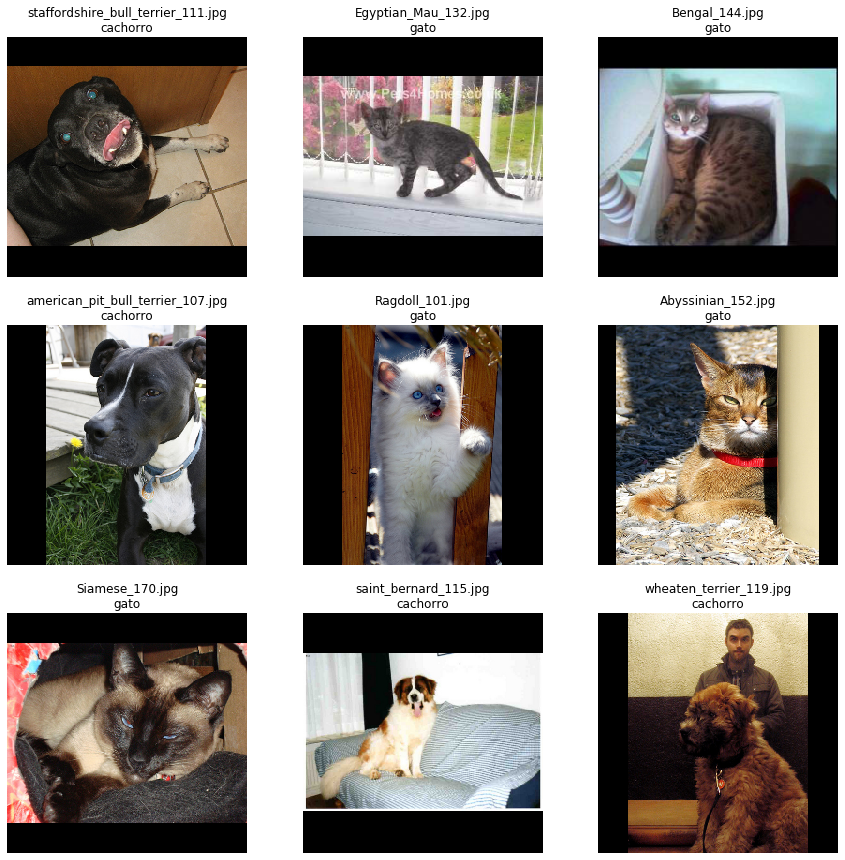

In [11]:
dic_labels = {0: 'gato', 1:'cachorro'}

plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))

for i, imgIndex in enumerate(np.random.randint(0, len(nome_imagens_filtrado), size = 9)):
    
    plt.subplot(3, 3, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'{nome_imagens_filtrado[imgIndex]}\n{dic_labels[labels[imgIndex]]}')
    plt.imshow(imgData[imgIndex])
plt.show()

### 5. Separando em treino e teste

In [12]:
X_tv, X_test, y_tv, y_test = train_test_split(
    imgData, 
    labels, 
    test_size = 0.2, 
    random_state = 7, 
    stratify = labels
    )

X_train, X_val, y_train, y_val = train_test_split(
    X_tv, 
    y_tv, 
    test_size = 0.1, 
    random_state = 7, 
    stratify = y_tv
    )

print(f'Dados de treino: {X_train.shape}')
print(f'Labels de treino: {len(y_train)}')
print(f'\nDados de Validação: {X_val.shape}')
print(f'Labels de Validação: {len(y_val)}')
print(f'\nDados de Teste: {X_test.shape}')
print(f'Labels de Teste: {len(y_test)}')

Dados de treino: (1436, 256, 256, 3)
Labels de treino: 1436

Dados de Validação: (160, 256, 256, 3)
Labels de Validação: 160

Dados de Teste: (400, 256, 256, 3)
Labels de Teste: 400


### 6. Gerador de imagens para  treinamento usando o Image Augmentation

In [13]:
batch = 32
train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')
train_data = train_gen.flow(x = X_train, y = y_train, batch_size = batch, shuffle = True)

### 6.1 Gerador de imagens para validação

In [14]:
val_gen = ImageDataGenerator(rescale = 1./255)
val_data = val_gen.flow(x = X_val, y = y_val, batch_size = batch, shuffle = True)

###  6.2 Gerador de imagens para  teste

In [15]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow(x = X_test, y = y_test, batch_size = batch)

### 6.3 Plot das imagens geradas

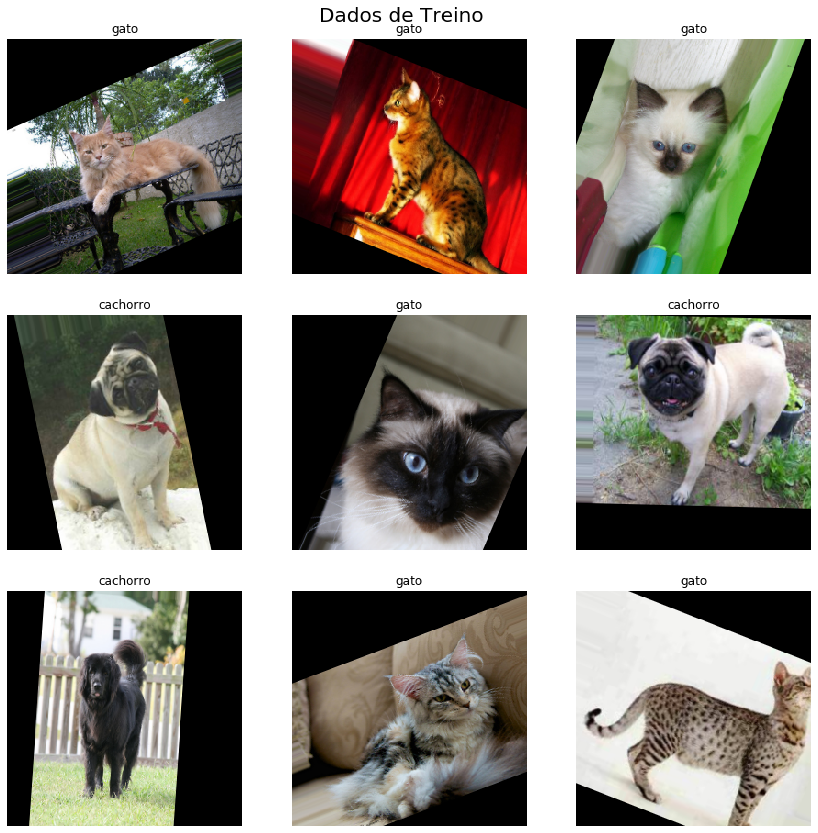

In [16]:
plot_imagens_geradas(train_data, "Dados de Treino", dic_labels)

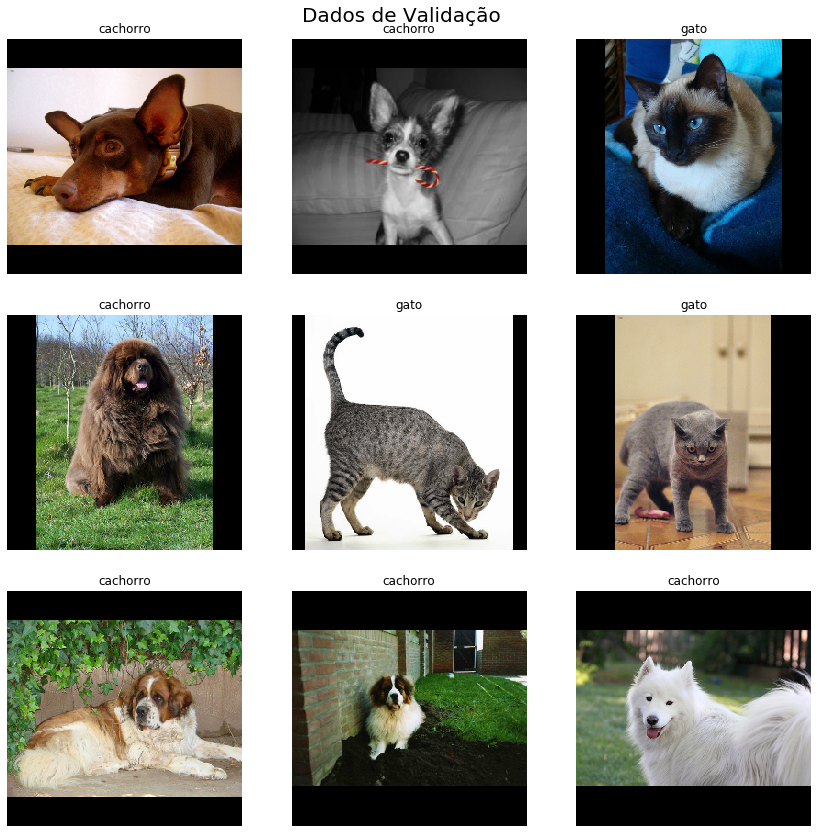

In [17]:
plot_imagens_geradas(val_data, "Dados de Validação", dic_labels)

### 7. Arquitetura da rede CNN

In [18]:
learning_rate = 0.0001

In [19]:
model = Sequential([
    Conv2D(32, 5, padding = 'same', input_shape = (*tamanho_imagem, 3), activation='relu'),
    MaxPooling2D(pool_size = (2, 2)),
    
    Conv2D(32, 4, padding = 'same', activation='relu'),
    MaxPooling2D(pool_size = (2, 2)),
    
    Conv2D(64, 4, padding = 'same', activation='relu'),
    MaxPooling2D(pool_size = (2, 2)),
    
    Conv2D(64, 3, padding = 'same', activation='relu'),
    MaxPooling2D(pool_size = (2, 2)),
    
    Conv2D(128, 3, padding = 'same', activation='relu'),
    MaxPooling2D(pool_size = (2, 2)),
    
    Conv2D(128, 3, padding = 'same', activation='relu'),
    MaxPooling2D(pool_size = (2, 2)),
    
    Conv2D(256, 2, padding = 'same', activation='relu'),
    MaxPooling2D(pool_size = (2, 2)),
    
    Flatten(),
    Dropout(0.2), 
    Dense(512, activation = 'relu'),
    Dropout(0.2), 
    Dense(256, activation = 'relu'),
    Dropout(0.2),
    Dense(units = 1, activation = 'sigmoid')
])
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate), loss = 'binary_crossentropy',
              metrics = ['accuracy'])
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        3

### 8. Treinamento da rede

In [20]:
%%time

epocas = 200
earlyStop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

history = model.fit(train_data, validation_data = val_data, epochs = epocas, verbose = 1, callbacks = [earlyStop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 45 steps, validate for 5 steps
Epoch 1/200
45/45 [==============================] - 18s 401ms/step - loss: 0.6943 - accuracy: 0.5042 - val_loss: 0.6929 - val_accuracy: 0.5063
Epoch 2/200
45/45 [==============================] - 15s 330ms/step - loss: 0.6930 - accuracy: 0.5237 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 3/200
45/45 [==============================] - 15s 335ms/step - loss: 0.6928 - accuracy: 0.5042 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 4/200
45/45 [==============================] - 15s 334ms/step - loss: 0.6919 - accuracy: 0.5132 - val_loss: 0.6896 - val_accuracy: 0.5688
Epoch 5/200
45/45 [==============================] - 15s 332ms/step - loss: 0.6917 - accuracy: 0.5181 - val_loss: 0.6878 - val_accuracy: 0.5875
Epoch 6/200
45/45 [==============================] - 15s 332ms/step - loss: 0.6854 - accuracy: 0.5836 - val_loss: 0.6839 - val_accuracy: 0.5875
Epoch 7/200
45/45 [==========================

45/45 [==============================] - 15s 329ms/step - loss: 0.2972 - accuracy: 0.8747 - val_loss: 0.4067 - val_accuracy: 0.8188
Epoch 57/200
45/45 [==============================] - 15s 330ms/step - loss: 0.2664 - accuracy: 0.8865 - val_loss: 0.4021 - val_accuracy: 0.8313
CPU times: user 17min 5s, sys: 19.5 s, total: 17min 25s
Wall time: 14min 15s


### 8.1 Resultado do treinamento

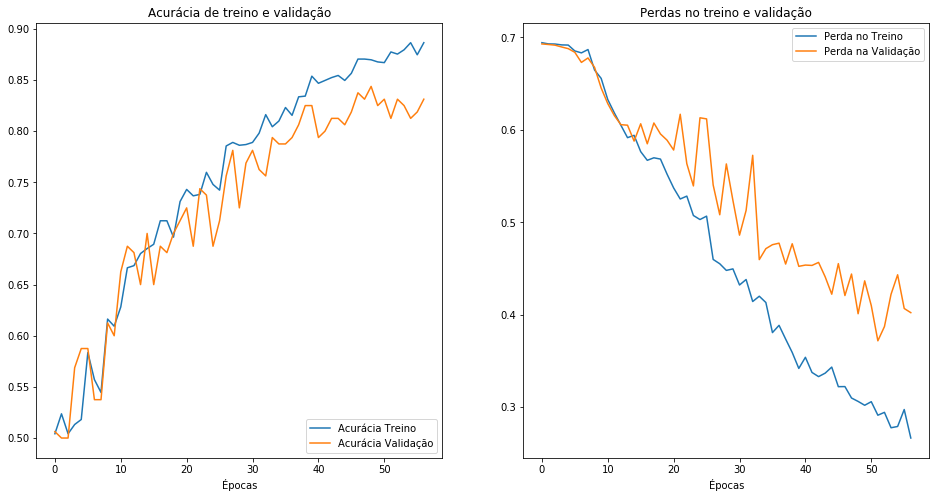

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Acurácia Treino')
plt.plot(epochs_range, val_acc, label = 'Acurácia Validação')
plt.legend(loc = 'lower right')
plt.title('Acurácia de treino e validação')
plt.xlabel('Épocas')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Perda no Treino')
plt.plot(epochs_range, val_loss, label = 'Perda na Validação')
plt.legend(loc = 'upper right')
plt.title('Perdas no treino e validação')
plt.xlabel('Épocas')
plt.show()

### 9. Avaliação do modelo nos dados de teste

In [22]:
test_loss, test_acc = model.evaluate(test_data, verbose = 0)

print(f"Perda nos dados de teste: {test_loss}")
print(f"Acurácia nos dados de teste: {test_acc}")

  ...
    to  
  ['...']
Perda nos dados de teste: 0.42356374172063976
Acurácia nos dados de teste: 0.8125


### 9.1 Resultado do modelo nos dados de teste

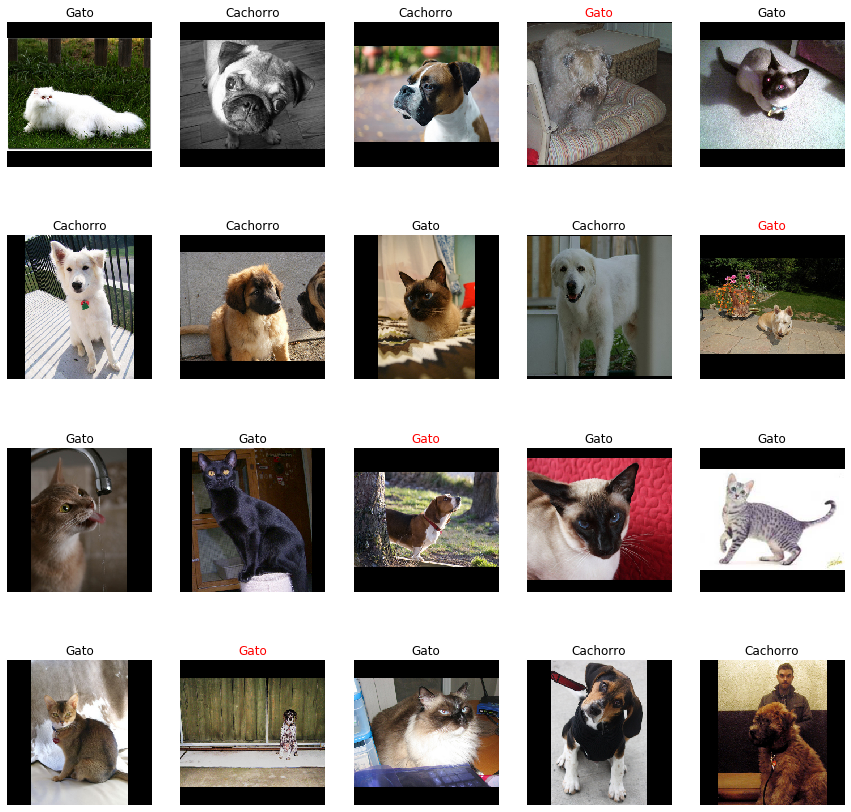

In [23]:
pred = model.predict(X_test/255)
pred = np.where(pred.flatten() > 0.5, 1, 0)

# plot de 20 amostras randômicas
p = np.random.permutation(len(pred))
plot_imagens(X_test[p[:20]], labels_palavras(pred[p[:20]]), labels_palavras(y_test[p[:20]]))


### 10. Matriz de confusão

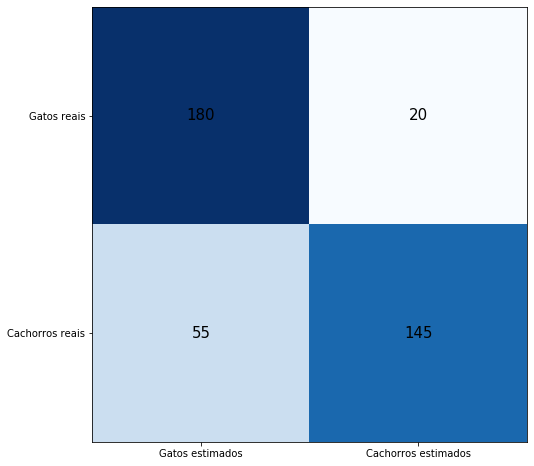

In [24]:
cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap=plt.cm.Blues)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Gatos estimados', 'Cachorros estimados'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Gatos reais', 'Cachorros reais'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center',  size=15)
plt.show()

### 11. Salvando o modelo

In [25]:
model.save('modelos/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: modelos/assets


### 12. Abrindo o modelo salvo e realizando a classificação

In [26]:
modelo_salvo = tf.keras.models.load_model('modelos/')

sm_test_loss, sm_test_acc = modelo_salvo.evaluate(test_data, verbose = 0)

print(f"Loss on Testing data: {sm_test_loss}")
print(f"Accuracy on Testing data: {sm_test_acc}")

  ...
    to  
  ['...']
Loss on Testing data: 0.4235633944089596
Accuracy on Testing data: 0.8125


### 12.1 Plotando os resultados da classificação

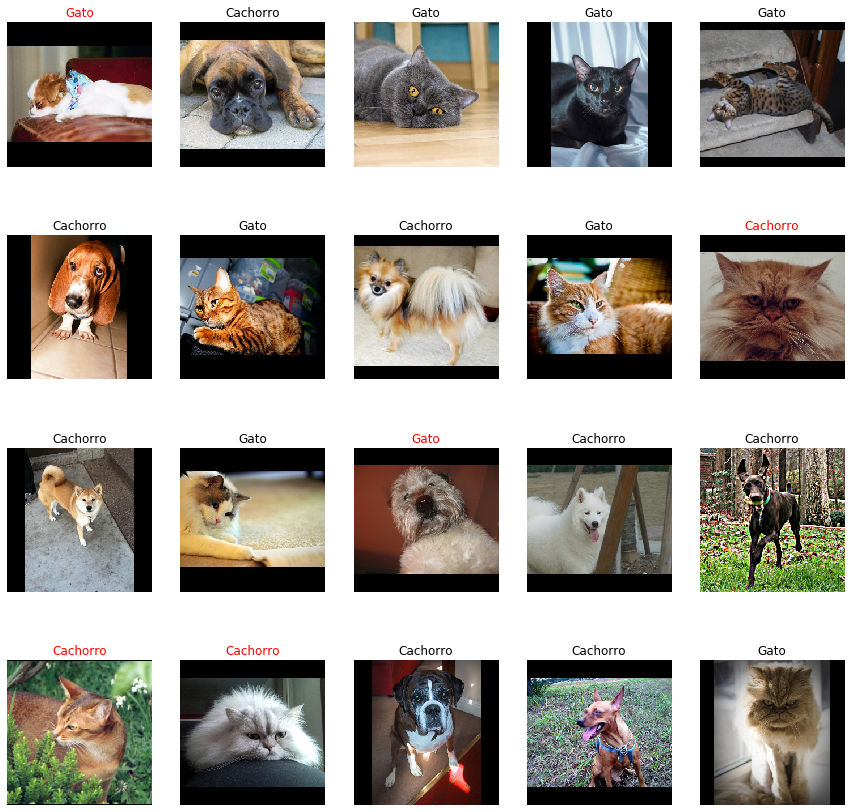

In [27]:
pred = modelo_salvo.predict(X_test/255)
pred = np.where(pred.flatten() > 0.5, 1, 0)

# plot de 20 amostras randômicas
p = np.random.permutation(len(pred))
plot_imagens(X_test[p[:20]], labels_palavras(pred[p[:20]]), labels_palavras(y_test[p[:20]]))